In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries

ALPHA_VANTAGE_API_KEY = os.environ.get("ALPHA_VANTAGE_API_KEY", "YOUR_API_KEY_HERE")

In [3]:
def randn_bm():
    """
    Generate a random number from a standard normal distribution using the Box-Muller transform.
    """
    u = 0
    v = 0
    while u == 0:
        u = np.random.rand()
    while v == 0:
        v = np.random.rand()
    return np.sqrt(-2.0 * np.log(u)) * np.cos(2.0 * np.pi * v)


In [4]:
def simulate_portfolio(initial_amount, monthly_contribution, years, annual_return, volatility):
    """
    Simulate a single asset's portfolio path using monthly compounding with Monte Carlo simulation.
    Returns the final portfolio value and the portfolio value path (list of monthly values).
    """
    months = years * 12
    portfolio = initial_amount
    monthly_return = (1 + annual_return) ** (1 / 12) - 1
    monthly_vol = volatility / np.sqrt(12)
    portfolio_values = []
    
    for _ in range(months):
        random_shock = monthly_vol * randn_bm()
        monthly_growth = monthly_return + random_shock
        portfolio = portfolio * (1 + monthly_growth) + monthly_contribution
        portfolio_values.append(portfolio)
    
    return portfolio, portfolio_values


In [5]:
def get_stock_stats(ticker, period_days=5*252):
    ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas', indexing_type='date')
    
    data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')

    data.sort_index(inplace=True)
    if len(data) < period_days:
        raise ValueError(f"Not enough data for ticker: {ticker}")
    data = data.tail(period_days)
    
    if "4. close" not in data.columns:
        raise ValueError(f"Expected '4. close' column not found for ticker: {ticker}")
    
    data['Daily Return'] = data["4. close"].pct_change()
    data = data.dropna(subset=["Daily Return"])
    if data.empty:
        raise ValueError(f"Not enough data to calculate daily returns for ticker: {ticker}")
    
    daily_return_mean = data['Daily Return'].mean()
    annual_return = (1 + daily_return_mean) ** 252 - 1
    annual_volatility = data['Daily Return'].std() * np.sqrt(252)
    
    return annual_return, annual_volatility


Portfolio Investment Simulation for Multiple Stocks (using Alpha Vantage API - Free Endpoint)


Enter stock tickers separated by commas (e.g., AAPL, MSFT, GOOGL):  AAPL, MSFT, GOOGL
Enter weights for each ticker as comma separated values (or press Enter for equal weighting):  


AAPL: Estimated Annual Return: 15.14%, Volatility: 44.36%
MSFT: Estimated Annual Return: 27.54%, Volatility: 27.66%
GOOGL: Estimated Annual Return: 8.75%, Volatility: 52.88%


Enter the overall initial investment amount ($):  50000
Enter the overall monthly contribution ($):  500
Enter the investment duration in years:  8
Enter number of simulation iterations (e.g., 1000):  100



Simulation Results for your Portfolio:
Median portfolio value after 8 years: $238,506.09
10th percentile portfolio value: $132,861.39
90th percentile portfolio value: $467,542.51


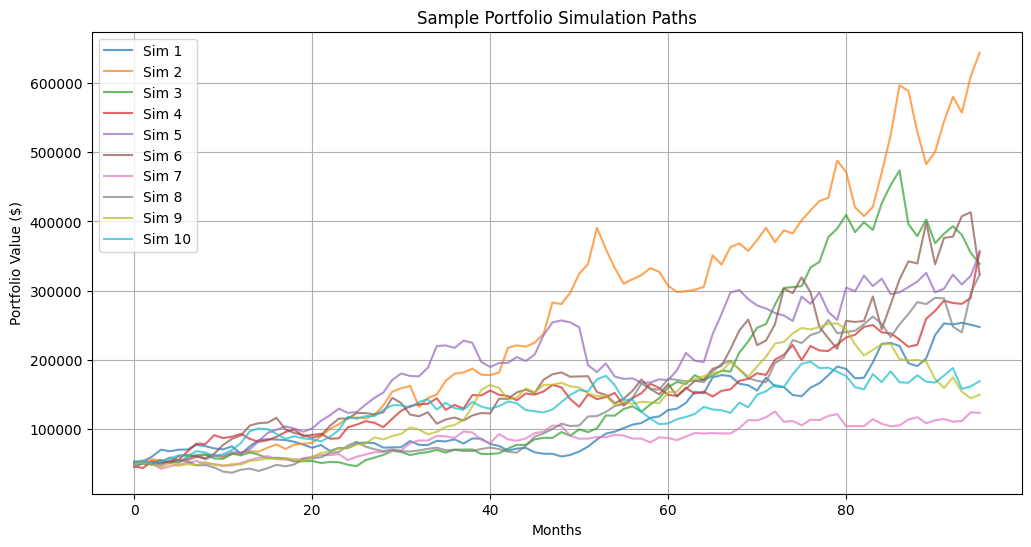

In [6]:
def main():
    print("Portfolio Investment Simulation for Multiple Stocks (using Alpha Vantage API - Free Endpoint)")
    tickers_input = input("Enter stock tickers separated by commas (e.g., AAPL, MSFT, GOOGL): ")
    tickers = [ticker.strip().upper() for ticker in tickers_input.split(",") if ticker.strip()]
    if not tickers:
        print("No tickers entered.")
        return

    weights_input = input("Enter weights for each ticker as comma separated values (or press Enter for equal weighting): ")
    if weights_input.strip():
        try:
            weights = [float(w.strip()) for w in weights_input.split(",")]
            if len(weights) != len(tickers):
                print("Number of weights does not match number of tickers. Using equal weighting instead.")
                weights = None
        except Exception as e:
            print("Error parsing weights:", e)
            weights = None
    else:
        weights = None
        
    if weights is None:
        weights = [1 / len(tickers)] * len(tickers)
    else:
        total = sum(weights)
        weights = [w / total for w in weights]

    # Get historical stats for each ticker using Alpha Vantage free endpoint
    stock_stats = {}
    for ticker in tickers:
        try:
            annual_ret, volatility = get_stock_stats(ticker)
            stock_stats[ticker] = {"annual_return": annual_ret, "volatility": volatility}
            print(f"{ticker}: Estimated Annual Return: {annual_ret * 100:.2f}%, Volatility: {volatility * 100:.2f}%")
        except Exception as e:
            print(f"Error retrieving stats for {ticker}: {e}")
            return

    try:
        initial_amount = float(input("Enter the overall initial investment amount ($): "))
        monthly_contribution = float(input("Enter the overall monthly contribution ($): "))
        years = int(input("Enter the investment duration in years: "))
        iterations = int(input("Enter number of simulation iterations (e.g., 1000): "))
    except ValueError:
        print("Invalid input. Please enter numeric values.")
        return

    # Allocate initial amount and monthly contributions per stock based on weights
    initial_allocations = {ticker: initial_amount * weight for ticker, weight in zip(tickers, weights)}
    monthly_allocations = {ticker: monthly_contribution * weight for ticker, weight in zip(tickers, weights)}
    
    portfolio_final_values = []
    portfolio_paths = []  # each path is a list of portfolio values over months
    months = years * 12

    for _ in range(iterations):
        combined_path = [0] * months
        for ticker in tickers:
            stats = stock_stats[ticker]
            init_amt = initial_allocations[ticker]
            monthly_amt = monthly_allocations[ticker]
            _, asset_path = simulate_portfolio(init_amt, monthly_amt, years, stats["annual_return"], stats["volatility"])
            combined_path = [sum(x) for x in zip(combined_path, asset_path)]
        portfolio_final_values.append(combined_path[-1])
        portfolio_paths.append(combined_path)
    
    portfolio_final_values = np.array(portfolio_final_values)
    
    median_value = np.percentile(portfolio_final_values, 50)
    p10 = np.percentile(portfolio_final_values, 10)
    p90 = np.percentile(portfolio_final_values, 90)
    
    print("\nSimulation Results for your Portfolio:")
    print(f"Median portfolio value after {years} years: ${median_value:,.2f}")
    print(f"10th percentile portfolio value: ${p10:,.2f}")
    print(f"90th percentile portfolio value: ${p90:,.2f}")
    
    plt.figure(figsize=(12, 6))
    for i in range(min(10, len(portfolio_paths))):
        plt.plot(portfolio_paths[i], alpha=0.7, label=(f"Sim {i+1}" if i < 10 else None))
    plt.title("Sample Portfolio Simulation Paths")
    plt.xlabel("Months")
    plt.ylabel("Portfolio Value ($)")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()